# Neutralization assays on RBD-absorbed serum samples and controls

I used commercially-available magnetic beads conjugated to SARS-CoV-2 RBD to deplete serum of RBD-binding antibodies. 
Control pre-pandemic serum spiked with either an RBD-binding monoclonal antibody, rREGN10987 (at 5, 25, or 50 ug/mL) or an NTD-binding antibody (at 50 ug/mL) were also incubated with the RBD beads to get an estimate of how well the depletion works. 

The process of pulling down the RBD antibodies involved diluting the serum 1:4 (because I added 50 uL serum + 150 uL of bead suspension at 1mg/mL). 
In one condition that we will not plot here, I used 2x as many beads, and thus added 50 uL serum + 300 uL of bead suspension, so this was a 1:7 dilution of the initial serum.

The pre-depletion serum was also diluted 1:4 (or 1:7, as appropriate) in PBS + 0.05% BSA (the buffer the beads were suspended in). 

Depletions were performed overnight at 4C in Eppendorf tubes in a tube rotator. 

SARS-CoV-2 RBD and spike ELISAs were performed on these samples to verify the degree of RBD antibody depletion (see the other Jupyter notebook in this directory).


Andrea Loes then performed neutralization assays on these samples. 
She started each sample at a slightly different initial dilution to capture the full neutralization curve for each sample, given that each serum has a different neutralization potency (determined in Kate's original paper).

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Import modules

In [28]:
import itertools
import math
import os
import warnings

from IPython.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import yaml

In [29]:
warnings.simplefilter('ignore')

In [30]:
plt.style.use('seaborn-white')
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
#theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))

### Create results directory

In [31]:
resultsdir='neut_results/'
os.makedirs(resultsdir, exist_ok=True)

Read config file

In [32]:
with open('rbd_absorption_config.yaml') as f:
    config = yaml.safe_load(f)

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [33]:
frac_infect = pd.DataFrame() # create empty data frame
neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
        .query('serum not in @neut_samples_ignore')
        .replace({'serum' : config['display_names']})
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

for s in config['neut_ignore_dilutions']:
    dil = config['neut_ignore_dilutions'][s]
    l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['concentration'] == dil)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['concentration'] == dil))].index)
    print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

for s in config['neut_ignore_dates']:
    dat = config['neut_ignore_dates'][s]
    l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['date'] == dat)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['date'] == dat))].index)
    print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

frac_infect.head(2)

Length before dropping anything = 1288
Length after dropping neut_samples_ignore = 1204
Dropping 4 rows
Length after dropping 23C_d26: 0.000205761 = 1200
Dropping 4 rows
Length after dropping 23C_d102: 0.000205761 = 1196
Dropping 28 rows
Length after dropping 24C_d32: 0.000205761 = 1168
Dropping 28 rows
Length after dropping 24C_d104: 0.000205761 = 1140
Dropping 28 rows
Length after dropping 1C_d26: 0.000205761 = 1112


,serum,virus,replicate,concentration,fraction infectivity,date,Unnamed: 6
0,13_d15,pre-depletion,1,0.016667,0.096030,201012,NaN
1,13_d15,pre-depletion,1,0.005556,0.201285,201012,NaN


### Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)
* Then pivot table, grouping by `serum` and keeping the `serum` and `ic50` columns
* Calculate fold-change ic50 post-depletion vs. pre-depletion
* Take fits.fitParams and drop all the pre-depletion samples 
* Keep `ic50_bound` and merge with fold_change

In [34]:
fits = neutcurve.CurveFits(frac_infect)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'depletion'})
    .assign(NT50=lambda x: 1/x['ic50'])
    # get columns of interest
    [['serum', 'depletion', 'ic50', 'NT50', 'ic50_bound']] 
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

fitparams.head(2)

,serum,depletion,ic50,NT50,ic50_bound,ic50_is_bound
0,13_d15,pre-depletion,0.001638,610.352369,interpolated,False
1,13_d15,post-depletion,0.006011,166.360761,interpolated,False


### Now make line plots, connecting pre-depletion and post-depletion NT50.
* facet plots on `serum`

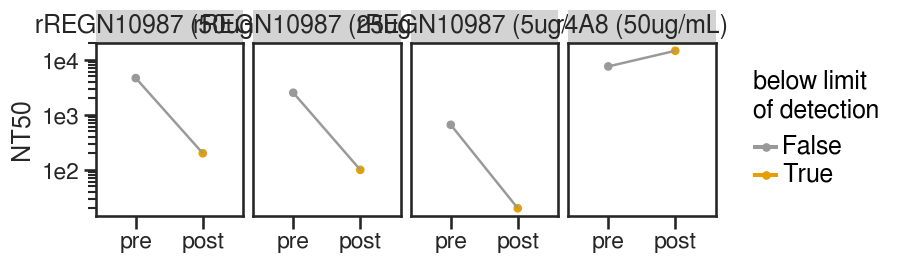

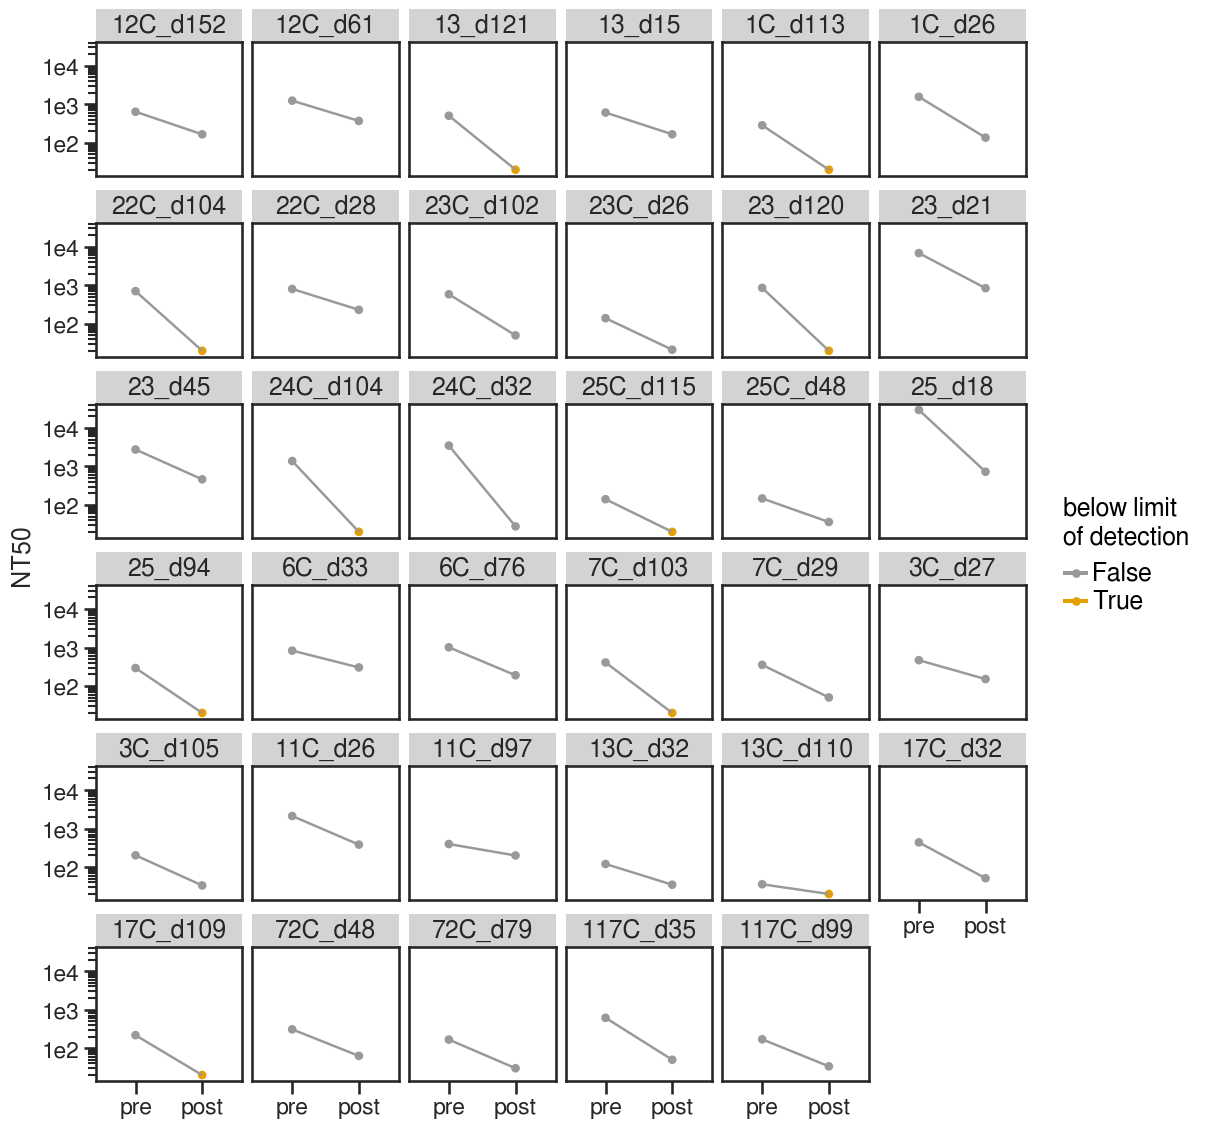

In [35]:
for group in config['depletion_groups']:
    
    antibody_order = list(group.values())[0]
    
    df = fitparams.query('serum in @antibody_order')
    
    df = (df
          .assign(serum= pd.Categorical(df['serum'], categories=antibody_order, ordered=True) )
          .replace({'pre-depletion': 'pre', 'post-depletion': 'post'})
         )
    
    df['depletion']=pd.Categorical(df['depletion'], categories=['pre', 'post'], ordered=True)
        
    nconditions = df['serum'].nunique()
    ncol = 6 if nconditions >= 6 else nconditions
    nrow = math.ceil(nconditions / ncol)
        
    p = (
        ggplot(df,
               aes('depletion', 
                   'NT50', 
                   group='serum', 
                   color='ic50_is_bound')) +
        geom_point(size=2.5) +
        geom_line(aes(group='serum'), size=1) +
        scale_x_discrete(name='') +
        scale_y_log10(name='NT50') +
        facet_wrap('~ serum', ncol=ncol, ) +
        theme(figure_size=(2 * ncol, 2.25 * nrow),
              subplots_adjust={'hspace':0.35}) +
#         geom_hline(yintercept=20, linetype='dashed', size=1,
#                     alpha=0.6, color=CBPALETTE[0]) +
        scale_color_manual(values=CBPALETTE,
                            name='below limit\nof detection')
        )
    
    _ = p.draw()
    p.save(f'./{resultsdir}/{list(group.keys())[0]}_neutdepletion.png')

### Make horizontal line plot connecting pre- and post-IC50
* Order with greatest fold-change at the top
* Put labels on far right with the % of neutralizing activity targeting the RBD (percent_RBD = 1-(1/foldchange))
* color by pre vs post
* shape is censored
* vertical line for limit of detection

In [36]:
foldchange = (
    fitparams
    .pivot_table(values='ic50', index=['serum'], columns=['depletion'])
    .reset_index()
    .rename(columns={'post-depletion': 'post-depletion_ic50', 'pre-depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            percent_RBD= lambda x: ((1-1/x['fold_change'])*100).astype(int)
           )
    .merge(fitparams.query('depletion=="post-depletion"')[['serum', 'ic50_is_bound']], on='serum')
    .assign(perc_RBD_str = lambda x: x['percent_RBD'].astype(str))
    .rename(columns={'ic50_is_bound': 'post_ic50_bound'})
    .merge(fitparams)
    )

foldchange['perc_RBD_str'] = np.where(foldchange['post_ic50_bound'], '>'+foldchange['perc_RBD_str']+'%', foldchange['perc_RBD_str']+'%')
foldchange['mapped'] = foldchange['serum'].apply(lambda x: True if x in config['mapped_samples'] else False)

foldchange.head(2)

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,post_ic50_bound,perc_RBD_str,depletion,ic50,NT50,ic50_bound,ic50_is_bound,mapped
0,117C_d35,0.020007,0.001628,12.289137,91,False,91%,pre-depletion,0.001628,614.245829,interpolated,False,False
1,117C_d35,0.020007,0.001628,12.289137,91,False,91%,post-depletion,0.020007,49.982830,interpolated,False,False


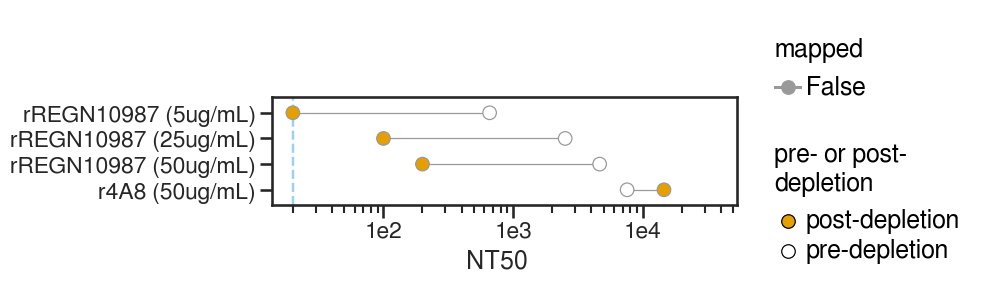

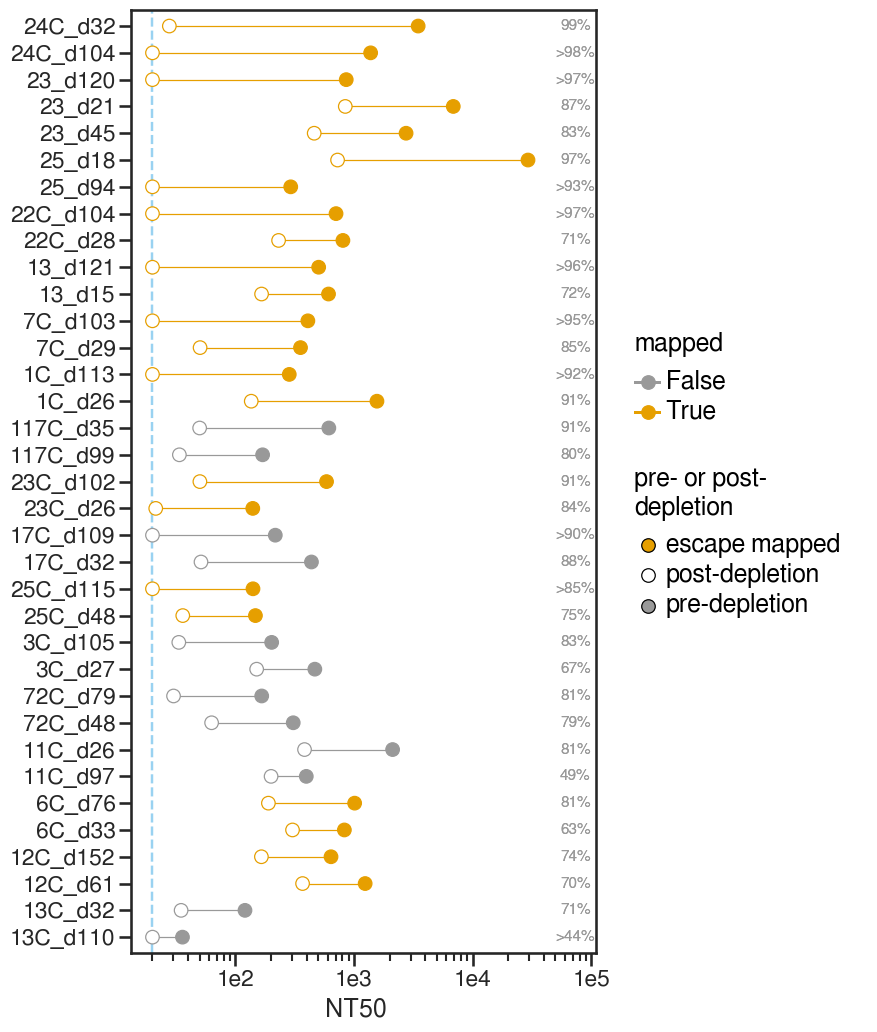

In [59]:
for group in config['depletion_groups']:
    
    sera = list(group.values())[0]
    df = foldchange.query('serum in @sera')
    
    if group == config['depletion_groups'][0]:
        # order sera by fold_change in ascending order 
        serum_order = df.sort_values('fold_change', ascending=True)['serum'].unique()
    else: # split PID_dPSO into 2 columns
        df=(df.assign(PID=lambda x: x['serum'].str.split('_d').str[0],
                            dPSO=lambda x: x['serum'].str.split('_d').str[1].astype(int),
                           )
           )
        
        df=(df.merge((df
                      [['PID', 'serum', 'fold_change']]
                      .groupby('PID')
                      .aggregate({'fold_change' : 'max'})
                      .reset_index()
                      .drop_duplicates()
                      .rename(columns={'fold_change':'max_fc'})
                     ), 
                    how='left', 
                    on='PID'
                   ))
        
        serum_order = df.sort_values(['max_fc', 'fold_change'], ascending=True)['serum'].unique()
    
    
    df = (df
          .assign(serum= pd.Categorical(df['serum'], categories=serum_order, ordered=True) )
          .replace({'pre-depletion': 'pre', 'post-depletion': 'post'})
         )
    df['fill_color'] = 'pre-depletion'
    df.loc[df.mapped == True, 'fill_color'] = 'escape mapped'
    df['fill_color'] = np.where(df['depletion'] == 'post', 'post-depletion', df['fill_color'])
    
    df['depletion']=pd.Categorical(df['depletion'], categories=['pre', 'post'], ordered=True)
    
    nconditions = df['serum'].nunique()
    
    p = (ggplot(df, aes(x='NT50',
                        y='serum',
                        color='mapped',
                        fill='fill_color', 
                        group='serum')) +
         scale_x_log10(name='NT50') +
         geom_vline(xintercept=config['NT50_LOD'], 
                    linetype='dashed', 
                    size=1, 
                    alpha=0.6, 
                    color=CBPALETTE[2]) +
         geom_line(alpha=1) +
         geom_point(size=5) +
         geom_text(aes(x=df['NT50'].max()*2.5, y='serum'), 
                   label=df['perc_RBD_str'],
                   color=CBPALETTE[0]
                  ) +
         ylab('') +
         theme(figure_size=(6, 0.35*nconditions)) +
         scale_color_manual(values=CBPALETTE) +
         scale_fill_manual(values=['#E69F00', '#FFFFFF', '#999999'], name='pre- or post-\ndepletion')
                    )

    _ = p.draw()
    p.save(f'./{resultsdir}/{list(group.keys())[0]}_IC50_lineplot.png')

Make boxplot or something

In [11]:
foldchange.head()

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,post_ic50_bound,perc_RBD_str,depletion,ic50,NT50,ic50_bound,ic50_is_bound,mapped
0,117C_d35,0.020007,0.001628,12.289137,91,False,91%,pre-depletion,0.001628,614.245829,interpolated,False,False
1,117C_d35,0.020007,0.001628,12.289137,91,False,91%,post-depletion,0.020007,49.982830,interpolated,False,False
2,117C_d99,0.029650,0.005892,5.032618,80,False,80%,pre-depletion,0.005892,169.735567,interpolated,False,False
3,117C_d99,0.029650,0.005892,5.032618,80,False,80%,post-depletion,0.029650,33.727090,interpolated,False,False
4,11C_d26,0.002610,0.000472,5.530512,81,False,81%,pre-depletion,0.000472,2118.601022,interpolated,False,False


In [12]:
sera = list(config['depletion_groups'][1].values())[0]
foldchange.query('serum in @sera')[['serum', 'percent_RBD', 'post_ic50_bound']].drop_duplicates()

,serum,percent_RBD,post_ic50_bound
0,117C_d35,91,False
2,117C_d99,80,False
4,11C_d26,81,False
6,11C_d97,49,False
8,12C_d152,74,False
10,12C_d61,70,False
12,13C_d110,44,True
14,13C_d32,71,False
16,13_d121,96,True
18,13_d15,72,False


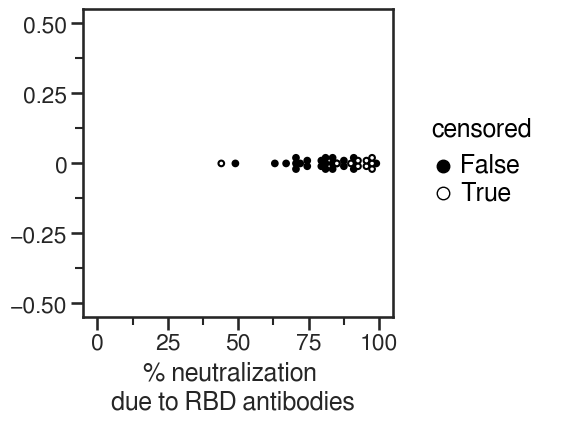

In [13]:
sera = list(config['depletion_groups'][1].values())[0]
    
p = (ggplot(foldchange.query('serum in @sera')[['serum', 'percent_RBD', 'post_ic50_bound']].drop_duplicates()
            .assign(lab='convalescent serum'), 
            aes(x='percent_RBD', fill='post_ic50_bound')
           ) +
     geom_dotplot(binwidth=2, stackdir='center') +
     scale_x_continuous(limits=[0,100]) +
     xlab('% neutralization \ndue to RBD antibodies') +
     ylab('')+
     scale_fill_manual(values=['black', 'white'], name='censored') +
     theme(figure_size=(4,4))
                )

_ = p.draw()
p.save(f'./{resultsdir}/percRBD_dotplot.png')

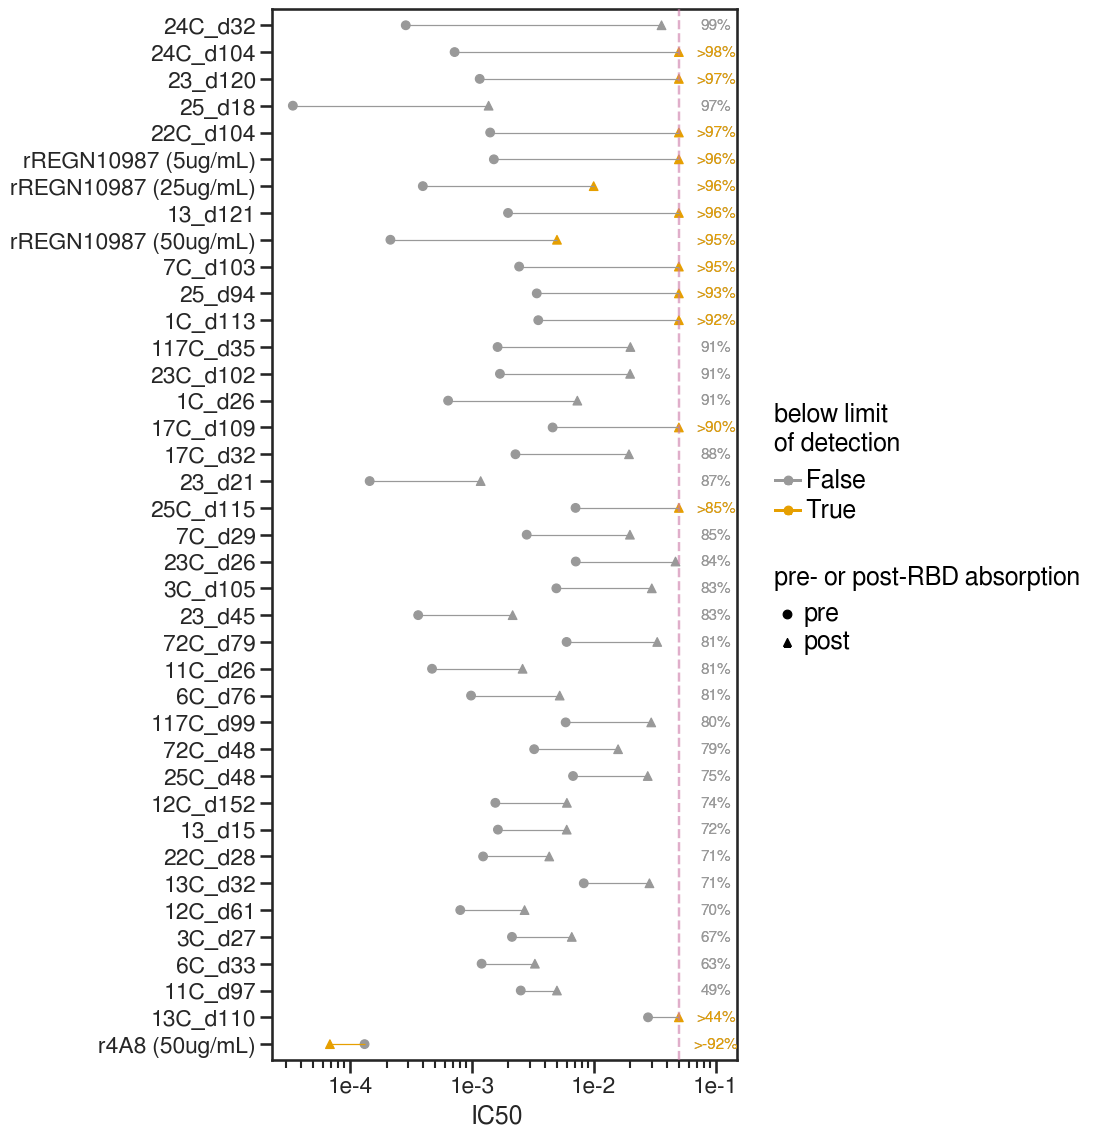

In [14]:
# order sera by fold_change in ascending order 
serum_order = foldchange.sort_values('fold_change', ascending=True)['serum'].unique()

df = foldchange.query('serum!=False')
df = (df
      .assign(serum= pd.Categorical(df['serum'], categories=serum_order, ordered=True) )
      .replace({'pre-depletion': 'pre', 'post-depletion': 'post'})
     )
df['depletion']=pd.Categorical(df['depletion'], categories=['pre', 'post'], ordered=True)

nconditions = df['serum'].nunique()

p = (ggplot(df, aes(x='ic50',
                    y='serum',
                    shape='depletion',
                    color='ic50_is_bound',
                    group='serum')) +
     geom_point(size=3) +
     geom_line() +
     scale_x_log10(name='IC50') +
     geom_vline(xintercept=1/config['NT50_LOD'], 
                linetype='dashed', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
     geom_text(aes(x=1/config['NT50_LOD'] * 2, y='serum'), 
               label=df['perc_RBD_str']
              ) +
     ylab('') +
     scale_color_manual(values=CBPALETTE,
                        name='below limit\nof detection' ) +
     scale_shape_manual(values=['o', '^'], name='pre- or post-RBD absorption') +
     theme(figure_size=(6, 0.35*nconditions)) 
                )

_ = p.draw()
p.save(f'./{resultsdir}/all_IC50_lineplot.png')

### Compare pre-depletion IC50s to [Kate's published data](https://academic.oup.com/jid/advance-article/doi/10.1093/infdis/jiaa618/5916372)

First read in [Supplementary File 2](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/jid/PAP/10.1093_infdis_jiaa618/1/jiaa618_suppl_supplementary_files_2.xlsx?Expires=1607057702&Signature=y8OMaiRqv333yv75g3X1SlHt9p-c98RXQvIm-q8ZmNaDlTHIIVlhoD8L1NXt8mWwDvEfFioxsoVpArW60VQ4mjPV-Qmu7O5N9-eKnnFeBincOg1fKxBBkzAe1TeT2NtqnAXFTEcZD30~Kt4UwViVxZUH8SMn4NuStwRREfG6C23TWTDTMLr9tlISxVZW65Cz0vK0hbhLv~3mC8IXes6mUh6VrHVDdSTmUBk0SN4Dhv6gLcMEmltdVHRgBFuuLFTq-VPRm7z43XV1FYiorDDrS6nmqihYtSQNV6sdbA2obqKDHt3xEcOK-ln~vtLcT0-FQ94p-1lFkf4h8-ebGrzLQw__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA). 
Then merge with our new data. 
Plot Kate's vs. Andrea's IC50s (Andrea's are done with D614G, but Kate's were done with D614).

Saving to ./neut_results//Crawford_Loes_NT50.pdf


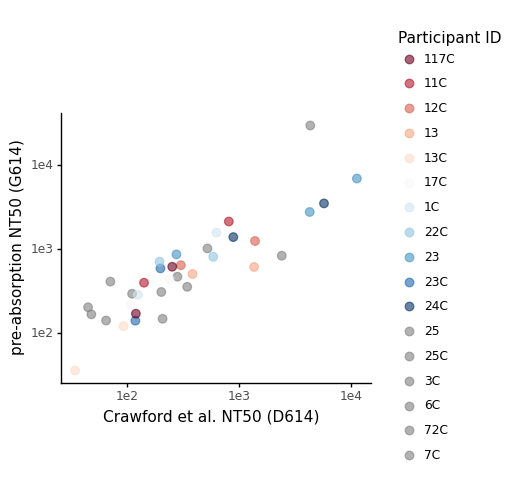

In [15]:
published_data = (pd.read_csv(config['published_metadata'], 
                              dtype={'Days Post-Symptom Onset': int}, 
                              index_col=0)
                  .assign(PID_date = lambda x: x['Participant ID'] + '_d' + x['Days Post-Symptom Onset'].astype(str))
                 )

p = (ggplot(pd.merge(fitparams.query('depletion=="pre-depletion"'),
                     published_data,
                     how='inner',
                     left_on='serum',
                     right_on='PID_date')
           ) +
     aes('NT50_y', 'NT50_x', color='Participant ID') +
     geom_point(size=3, alpha=0.6) +
     scale_x_log10() +
     scale_y_log10() +
     theme_classic() +
     theme(figure_size=(4, 3.5),
           ) +
     xlab('Crawford et al. NT50 (D614)') +
     ylab('pre-absorption NT50 (G614)') +
     scale_color_brewer(type="diverging", palette="RdBu", name='Participant ID')
     )

_ = p.draw()

plotfile = f'./{resultsdir}/Crawford_Loes_NT50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

In [16]:
(pd.merge(fitparams.query('depletion=="pre-depletion"'),
                     published_data,
                     how='inner',
                     left_on='serum',
                     right_on='PID_date')).head()

,serum,depletion,ic50,NT50_x,ic50_bound,ic50_is_bound,sample,Participant ID,Sex,Age,Severity,Days Post-Symptom Onset,IC50,NT50_y,RBD IgA,RBD IgG,RBD IgM,Spike IgG,PID_date
0,13_d15,pre-depletion,0.001638,610.352369,interpolated,False,191A5833,13,Male,54.0,Symptomatic Hospitalized,15,0.000733,1364.855856,4.141832,11.417218,1.562770,13.706617,13_d15
1,6C_d76,pre-depletion,0.000986,1013.710417,interpolated,False,B82F21E3,6C,Female,64.0,Symptomatic Hospitalized,76,0.001916,521.941850,4.444044,12.621242,1.224445,13.793956,6C_d76
2,12C_d152,pre-depletion,0.001561,640.728766,interpolated,False,79BD0F7A,12C,Male,68.0,Symptomatic Non-Hospitalized,152,0.003314,301.775043,6.345139,13.934689,1.639293,14.500748,12C_d152
3,25_d18,pre-depletion,0.000034,29366.995924,interpolated,False,4B0E5065,25,Female,31.0,Symptomatic Hospitalized,18,0.000230,4342.522093,2.430243,12.875956,6.677572,14.895590,25_d18
4,25_d94,pre-depletion,0.003412,293.069811,interpolated,False,D1337074,25,Female,31.0,Symptomatic Hospitalized,94,0.009041,110.604531,1.763297,9.360726,1.378046,13.575003,25_d94


Saving to ./neut_results//Crawford_Loes_NT50_facet.pdf


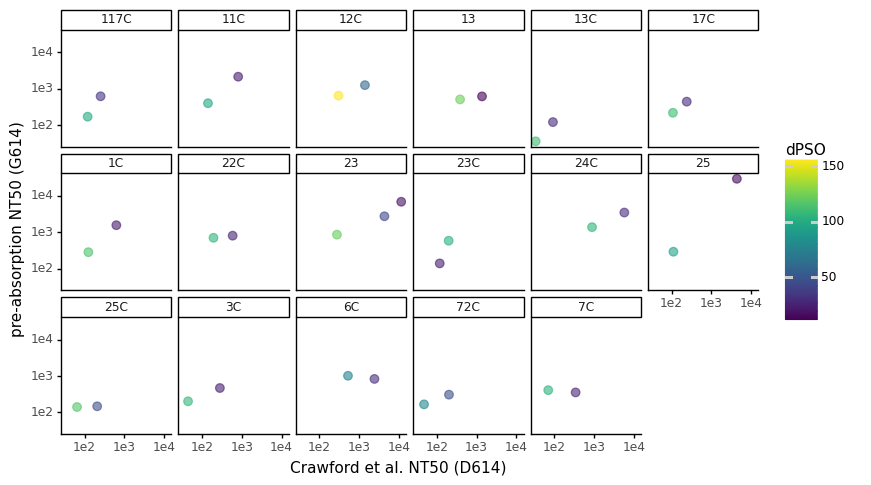

In [17]:
nconditions = fitparams['serum'].nunique()
ncol = 6 if nconditions >= 6 else nconditions
nrow = math.ceil(nconditions / ncol)

p = (ggplot(pd.merge(fitparams.query('depletion=="pre-depletion"'),
                     published_data,
                     how='inner',
                     left_on='serum',
                     right_on='PID_date')
            .assign(PID=lambda x: x['Participant ID'])
           ) +
     aes('NT50_y', 'NT50_x', color='Days Post-Symptom Onset') +
     geom_point(size=3, alpha=0.6) +
     scale_x_log10() +
     scale_y_log10() +
     facet_wrap('~ PID', ncol=ncol) +
     theme_classic() +
     theme(
           figure_size=(1.5 * ncol, 0.75 * nrow),
           ) +
     xlab('Crawford et al. NT50 (D614)') +
     ylab('pre-absorption NT50 (G614)') +
     labs(color='dPSO')
     )

_ = p.draw()

plotfile = f'./{resultsdir}/Crawford_Loes_NT50_facet.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

### Calculate fold-change IC50 and NT50

In [18]:
foldchange = (
    fitparams
    .pivot_table(values='ic50', index=['serum'], columns=['depletion'])
    .reset_index()
    .rename(columns={'post-depletion': 'post-depletion_ic50', 'pre-depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            post_NT50=lambda x: 1/x['post-depletion_ic50'],
            pre_NT50=lambda x: 1/x['pre-depletion_ic50']
           )
    .merge(fitparams.query('depletion=="post-depletion"')[['serum', 'ic50_is_bound']])
    )

foldchange.to_csv(f'{resultsdir}/rbd_depletion_foldchange_ic50.csv', index=False)
foldchange

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,post_NT50,pre_NT50,ic50_is_bound
0,117C_d35,0.020007,0.001628,12.289137,49.982830,614.245829,False
1,117C_d99,0.029650,0.005892,5.032618,33.727090,169.735567,False
2,11C_d26,0.002610,0.000472,5.530512,383.075048,2118.601022,False
3,11C_d97,0.004997,0.002523,1.981000,200.117113,396.431914,False
4,12C_d152,0.006030,0.001561,3.863613,165.836664,640.728766,False
5,12C_d61,0.002711,0.000804,3.370658,368.849022,1243.263729,False
6,13C_d110,0.050000,0.027923,1.790609,20.000000,35.812190,True
7,13C_d32,0.028672,0.008295,3.456373,34.876922,120.547637,False
8,13_d121,0.050000,0.001983,25.208003,20.000000,504.160069,True
9,13_d15,0.006011,0.001638,3.668848,166.360761,610.352369,False


### Plot post- vs. pre-depletion NT50

Saving to neut_results//antibody_controls_pre_post_NT50.pdf
Saving to neut_results//serum_samples_pre_post_NT50.pdf


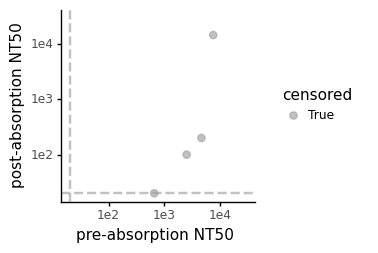

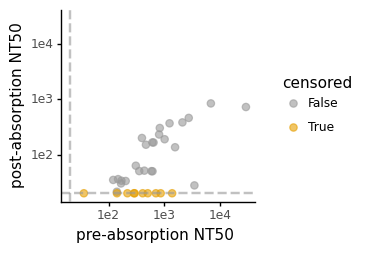

In [19]:
for group in config['depletion_groups']:
    serum_samples = list(group.values())[0]
    
    p = (ggplot(foldchange.query('serum in @serum_samples')) +
         aes('pre_NT50', 'post_NT50', color='ic50_is_bound') +
         geom_point(size=2.5, alpha=0.6) +
         scale_x_log10(limits=[config['NT50_LOD'],foldchange['pre_NT50'].max()], 
                       name='pre-absorption NT50') +
         scale_y_log10(limits=[config['NT50_LOD'],foldchange['pre_NT50'].max()], 
                       name='post-absorption NT50') +
         theme_classic() +
         theme(figure_size=(2.5, 2.5),
               ) +
         geom_hline(yintercept=config['NT50_LOD'], linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
         geom_vline(xintercept=config['NT50_LOD'], linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
         scale_color_manual(values=CBPALETTE,
                            name='censored')
         )

    _ = p.draw()

    plotfile = f'{resultsdir}/{list(group.keys())[0]}_pre_post_NT50.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

### Make plot showing fold-change IC50 post- vs. pre-depletion
The order that samples are plotted here is determined in the config file.

Saving to neut_results//fold_change_IC50.pdf


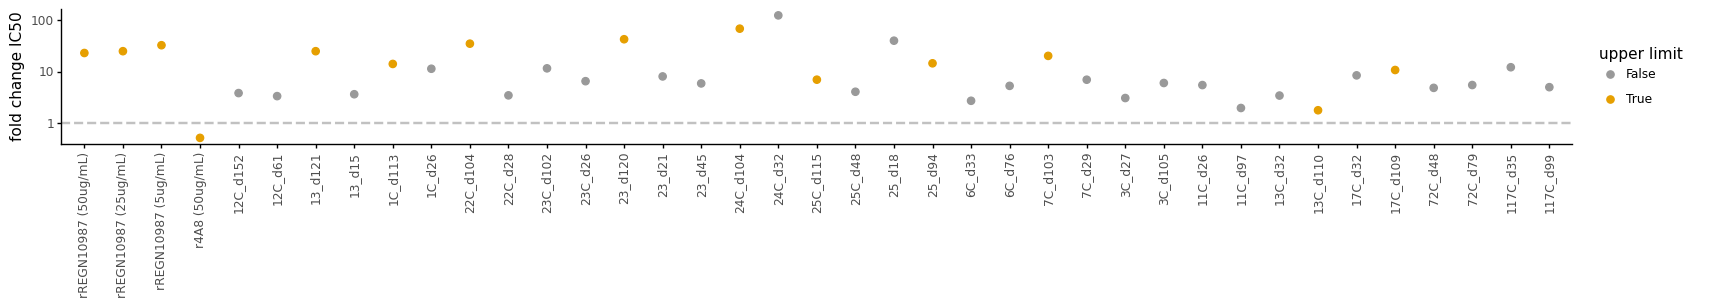

In [20]:
serum_order = []

for group in config['depletion_groups']:
    serum_order = serum_order + list(group.values())[0]
    
p = (ggplot(foldchange.assign(serum=pd.Categorical(foldchange['serum'], categories=serum_order, ordered=True))) +
     aes('serum', 'fold_change', color='ic50_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * foldchange['serum'].nunique(), 1.75),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     scale_color_manual(values=CBPALETTE,
                        name='upper limit') +
     labs(x = "")
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Print samples by descending fold-change IC50 (so we can see the most RBD-targeted ones at the top of the list!). I am only printing a few columns of interest to make it less visually distracting.

In [21]:
(foldchange
 .sort_values(by=['fold_change'], ascending=False)
 [['serum', 'pre_NT50', 'fold_change', 'ic50_is_bound']])

,serum,pre_NT50,fold_change,ic50_is_bound
22,24C_d32,3479.699831,125.366727,False
21,24C_d104,1383.047158,69.152358,True
18,23_d120,861.163942,43.058197,True
25,25_d18,29366.995924,40.363676,False
14,22C_d104,706.369699,35.318485,True
38,rREGN10987 (5ug/mL),658.878780,32.943939,True
36,rREGN10987 (25ug/mL),2521.292258,25.212923,True
8,13_d121,504.160069,25.208003,True
37,rREGN10987 (50ug/mL),4650.560175,23.252801,True
33,7C_d103,408.812677,20.440634,True


This is great! 
We can see that for several samples, the fold-change in IC50 is even greater than was observed for the monoclonal antibody, rREGN10987. 
Our fold-change is limited by two factors:
1. The IC50 of the pre-depletion sample (the more potent the pre-depletion IC50, the greater magnitude of change we are able to detect)
2. The dilutions used on the post-depletion sample, which determine the bounds or upper limit of IC50 that can be calculated.

For a number of samples, our post-depletion IC50 is bound because `neutcurve` is unable to determine an IC50 with the dilutions we used. 
So, do keep this in mind when interpreting the fold-change IC50.
However -- the max fold-change we are able to detect is related to the potency of the pre-depletion serum, and we probably want to be using the *most potent sera* that are *the most RBD-targeting* so I think we can still find these bounded numbers as useful. 

You could also imagine taking this list and using it to re-order the samples in the config file so that plots are made by order of RBD-directed neut potency. 
Since I am currently still picking validation mutants, I like having them in order as they are in `dms-view`, as this allows me to scan visually back and forth between these files and outputs, and toggle through `dms-view` pages.

Now let's examine by date.

Saving to ./neut_results//depletion_overtime_facet.pdf


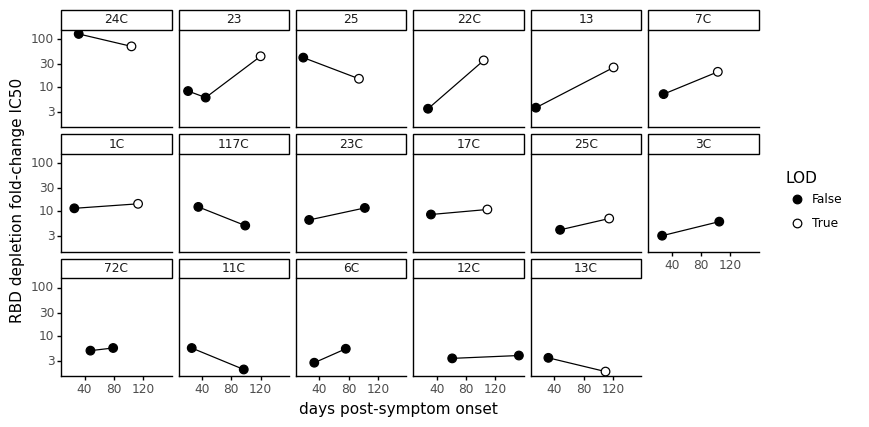

In [22]:
sera = []
sera = list(config['depletion_groups'][1].values())[0] # these are the sera
#sera.remove('pre-pandemic')
    
serum_foldchange = (foldchange
                    .query('serum in @sera')
                    .assign(PID=lambda x: x['serum'].str.split('_d').str[0],
                            dPSO=lambda x: x['serum'].str.split('_d').str[1].astype(int),
                           )
                   )
serum_foldchange['dPSO_group'] = (serum_foldchange['dPSO']
                                  .apply(lambda x: 'early' if x<=45 else 'late')
                                 )

# This would manually define serum plotting order according to config file
# sera_PID = [x.split('_d')[0] for x in sera]
# PID_order = list(dict.fromkeys(sera_PID))

# Instead, define serum plotting order according to max_fc for one PID
PID_order = serum_foldchange.sort_values('fold_change', ascending=False)['PID'].unique()
serum_foldchange['PID'] = pd.Categorical(serum_foldchange['PID'], categories=PID_order, ordered=True)

nconditions = serum_foldchange['serum'].nunique()
ncol = 6 if nconditions >= 6 else nconditions
nrow = math.ceil(nconditions / ncol)

p = (ggplot(serum_foldchange
           ) +
     aes('dPSO', 'fold_change', group='PID', fill='ic50_is_bound') +
     geom_line(aes(group='PID'), size=0.5) +
     geom_point(size=3, alpha=1) +
     scale_y_log10() +
     facet_wrap('~ PID', ncol=ncol) +
     theme_classic() +
     theme(
           figure_size=(1.5 * ncol, 0.75 * nrow),
           ) +
     xlab('days post-symptom onset') +
     ylab('RBD depletion fold-change IC50') +
     labs(fill='LOD') +
     scale_fill_manual(values=['black', 'white'])
     )

_ = p.draw()

plotfile = f'./{resultsdir}/depletion_overtime_facet.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

In [23]:
serum_foldchange.head()

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,post_NT50,pre_NT50,ic50_is_bound,PID,dPSO,dPSO_group
0,117C_d35,0.020007,0.001628,12.289137,49.982830,614.245829,False,117C,35,early
1,117C_d99,0.029650,0.005892,5.032618,33.727090,169.735567,False,117C,99,late
2,11C_d26,0.002610,0.000472,5.530512,383.075048,2118.601022,False,11C,26,early
3,11C_d97,0.004997,0.002523,1.981000,200.117113,396.431914,False,11C,97,late
4,12C_d152,0.006030,0.001561,3.863613,165.836664,640.728766,False,12C,152,late


### Plot samples by group (groupings and order specified in config file)

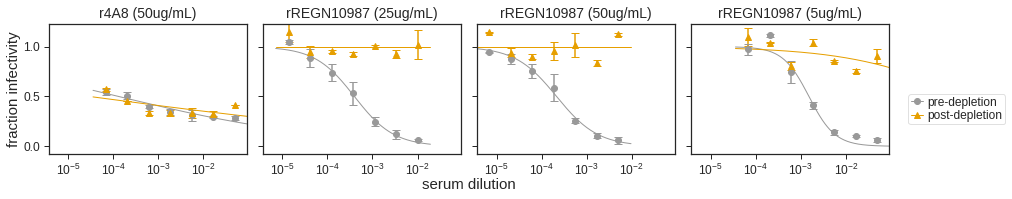

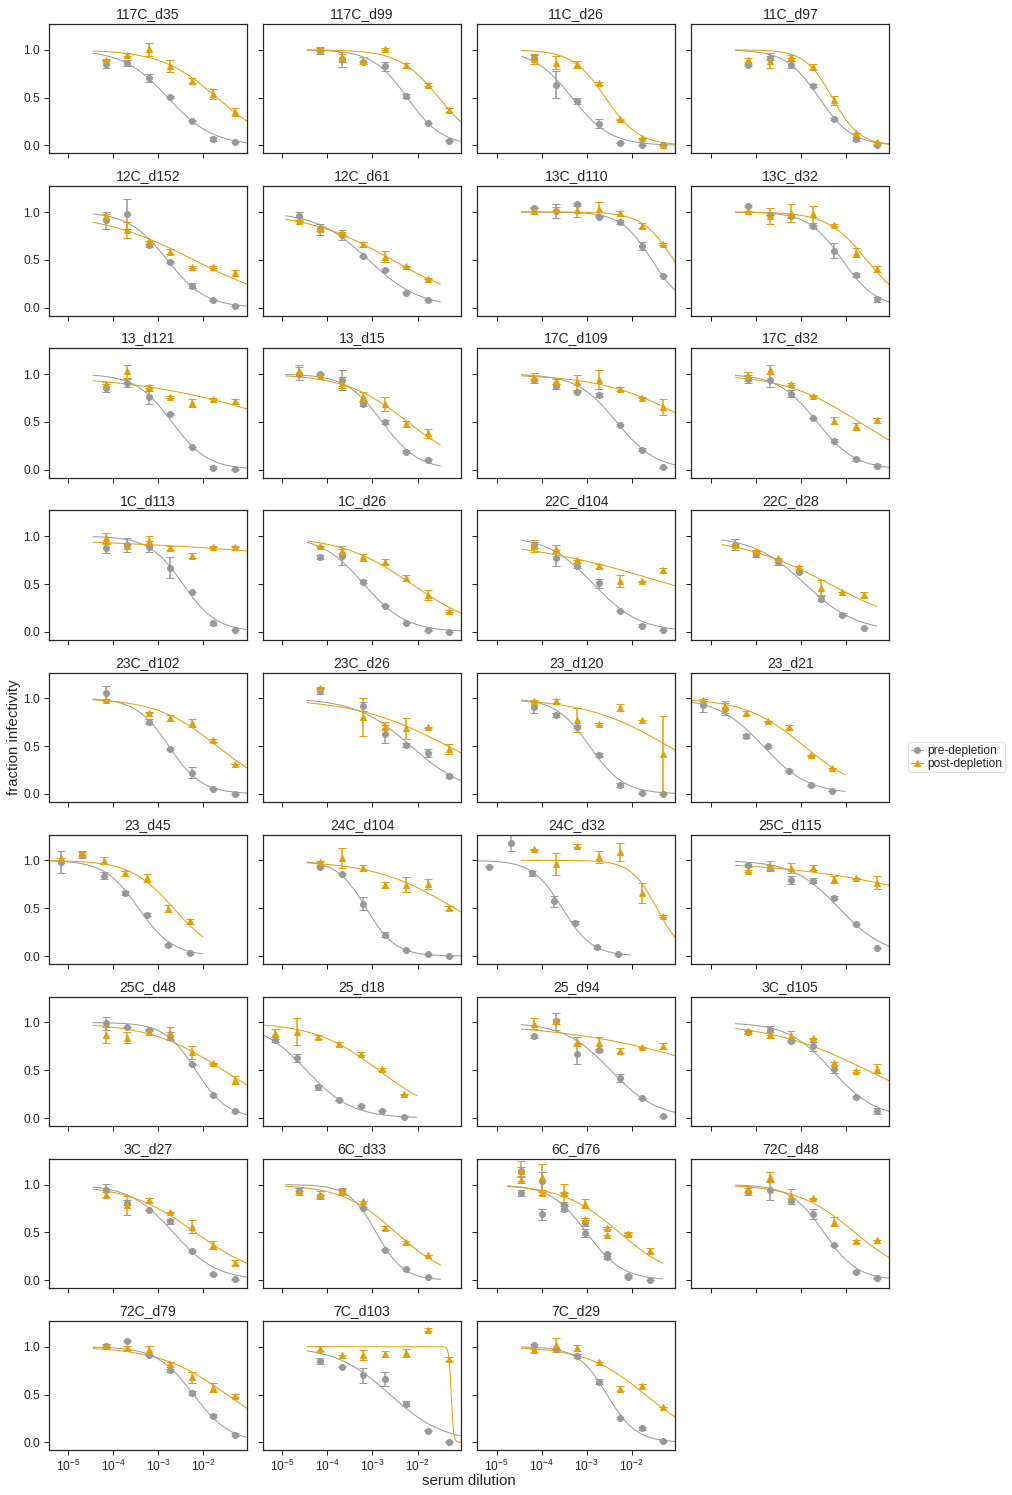

In [24]:
for group in config['depletion_groups']:
    antibody_order = list(group.values())[0]
    plot_df = (foldchange
               .query('serum in @antibody_order')
              )
    plot_df['serum'] = pd.Categorical(plot_df['serum'], categories=antibody_order, ordered=True)
    
    fig, axes = fits.plotSera(sera=plot_df['serum'].tolist(),
                              xlabel='serum dilution')

    # save plot files
    plotfile = PdfPages(f'{resultsdir}/{list(group.keys())[0]}_frac_infectivity.pdf')
    plotfile.savefig(bbox_inches='tight', transparent=True)
    plotfile.close()

In [25]:
!jupyter nbconvert rbd_depletion_neuts.ipynb --to html

[NbConvertApp] Converting notebook rbd_depletion_neuts.ipynb to html
[NbConvertApp] Writing 1820346 bytes to rbd_depletion_neuts.html
